# Make T-shirt

In [1]:
import numpy as np
import matplotlib.image as mim
import matplotlib.pyplot as plt
%matplotlib inline

Shirt colours, other than white and vintage white:

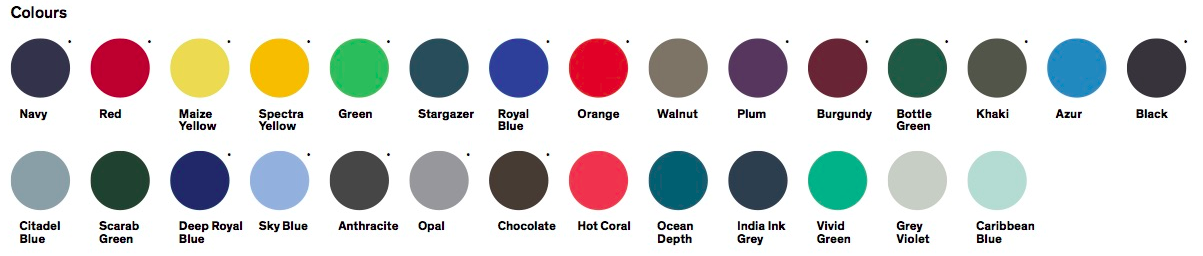

In [2]:
from IPython.display import Image

Image('./tshirt_colours.png')

## Import image

We use an image to guide the shape and colour.

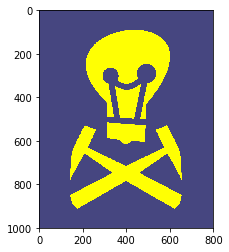

In [3]:
img = mim.imread('tshirt_skull_art_YELLOW.png')[:, :, :3]
img = (img*255).astype(np.uint8)
plt.imshow(img)

## Quantize the colours

We need 2 colours only in this image.

In [23]:
n_colours = 2

In [15]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [28]:
h, w, d = img.shape
im_ = img.reshape((w * h, d))

kmeans = KMeans(n_clusters=n_colours).fit(im_)

In [33]:
p = kmeans.cluster_centers_
labels = kmeans.predict(im_)

Use fancy indexing and reshape to get our image back, now with only 2 colours:

In [48]:
img = p[labels].reshape((h, w, 3)).astype(np.uint8)

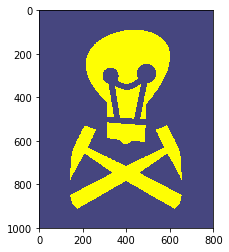

In [49]:
plt.imshow(img)

## Make an SVG

We'll use the `svgwrite` library. Install it thusly:

    conda install -c omnia svgwrite

In [50]:
import svgwrite

In [51]:
height, width, _ = img.shape

fname = "tshirt.svg"
size = ("{}px".format(width), "{}px".format(height))

text = "SUBSURFACEHACKATHONPARIS2017"
w = 45
h = int(w * 1.5)

# Most of the colours come from the PNG template, but not these:
bg_colour = [44, 62, 78]  # India Ink Grey shirt
highlight = [255,128,0]  # orange

Define some special lines, which will contain highlighted text. The keys are the line numbers, the `offset` is the starting point I want on that line, so the text appears in the right place. The `start` is the point in the original string at which to start highlighting, and the `end` is the end(!). `rgb` is the colour for the highlighted text.

In [52]:
special = {
    10: {'offset':10, 'start':-1, 'end':10, 'rgb':highlight},
    11: {'offset':16, 'start':9, 'end':19, 'rgb':highlight},
    13: {'offset':26, 'start':18, 'end':24, 'rgb':highlight},
    14: {'offset':33, 'start':23, 'end':28, 'rgb':highlight},
}

Not sure how this is going to unfold, so do it procedurally...

In [53]:
from random import randint

dwg = svgwrite.Drawing(filename=fname,
                       size=size)

background = 'rgb({},{},{})'.format(*bg_colour)
dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), rx=None, ry=None, fill=background))

last_start = -1
l = len(text)

this_line = ''

for line in range(h):
    # y-position.
    y = (line + 1) * (height/h)
    
    # Find the start point.
    s = special.get(line)
    if s is None:
        start = randint(0, l)
    else:
        start = s['offset']

    if start == last_start:
        start += 2
        start %= w
    last_start = start
    
    # Need var to help decide on 'special' words.
    a = l - start

    # Make the string for this line.
    t = (3*text)[start:start+w]

    # Replace ends of lines with spaces.
    u, v = randint(0,8), randint(0, 8)
    if (line == 0) or (line == h-1):
        u = v = int(w/3)
    if (line == 1) or (line == h-2):
        u = v = int(w/4)
    t = u*' ' + t[u:-u or None] + u*' '
        
    # Build up the line.
    for i, c in enumerate(t):
        x = i * (width/w)
        if s and (a+s['start'] < i < a+s['end']):    
            colour = s['rgb']
            weight = '700'
        else:
            colour = img[int(y)-1, int(x)-1]
            weight = '400'
        fill = "rgb({},{},{})".format(*colour)
        style = "font-size:{}px;".format((height/h)-1)
        style += " font-family:'DejaVu Sans Mono';"
        style += " font-weight:{};".format(weight)
        char = dwg.text(c,
                        insert=(x, y),
                        fill=fill,
                        style=style,
                       )
        dwg.add(char)

In [54]:
dwg.save()

In [55]:
from IPython.display import HTML

HTML(dwg.tostring())